# Homework: 8

## Dataset

In this homework, we'll build a model for predicting if we have an image of a dino or a dragon. For this, we will use the "Dino or Dragon?" dataset that can be downloaded from [Kaggle](https://www.kaggle.com/datasets/agrigorev/dino-or-dragon). 

You can get a wget-able version [here](https://github.com/alexeygrigorev/dino-or-dragon/releases/download/data/dino-dragon.zip):

```bash
wget https://github.com/alexeygrigorev/dino-or-dragon/releases/download/data/dino-dragon.zip
unzip dino-dragon.zip
```

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

**Note:** You will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
You can also use a computer without a GPU (e.g. your laptop), but it will be slower.

In [1]:
import os
import warnings

from collections import namedtuple
from pathlib import Path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# squash error messages and warnings and set global seed value
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)
warnings.simplefilter(action='ignore')
warnings.filterwarnings(action='ignore')
np.random.seed(42)
%matplotlib inline

In [3]:
from tensorflow import keras
from tensorflow.keras.applications.xception import decode_predictions, preprocess_input, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

In [4]:
# allocate more memory to tensorflow
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## Data Preparation

The dataset contains around 1900 images of dinos and around 1900 images of dragons. 

The dataset contains separate folders for training and validation. 

## Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

- **`binary crossentropy`**
- `focal loss`
- `mean squared error`
- `categorical crossentropy`

Note: since we specify an activation for the output layer, we don't need to set `from_logits=True`

### Generate Training and Testing Sets

In [5]:
def gen_train_test_sets(training, testing, target_size=(150, 150)):
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_ds = train_gen.flow_from_directory(
        training,
        target_size=target_size,
        batch_size=32,
        seed=42,
    )

    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_ds = test_gen.flow_from_directory(
        testing,
        target_size=target_size,
        shuffle=False,
        seed=42,
    )
    
    return train_gen, train_ds, test_gen, test_ds

### Create the model

In [6]:
def create_model(epochs):
    inputs = keras.Input(shape=(150, 150, 3))
    convolution = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    reduce = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolution)
    vectors = keras.layers.Flatten()(reduce)
    dense = keras.layers.Dense(64, activation='relu')(vectors)
    outputs = keras.layers.Dense(1, activation='sigmoid')(dense)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.SGD(lr=0.002, momentum=0.8)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Evaluate the model

In [7]:
def evaluate_model(model, train_ds, test_ds, steps=12):
    test_ds.reset()
    pred = model.predict_generator(
        test_ds,
        steps=steps,
        verbose=0,
    )

    predicted_class_indices = np.argmax(pred, axis=1)

    labels = (train_ds.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    
    return predictions

### Plot the model

In [8]:
def plot_history(history, loss_function):
    plt.plot(history.history['val_accuracy'], label='val')
    plt.plot(history.history['accuracy'], label='train')
    plt.xticks(np.arange(10))
    plt.title(f"{loss_function}: {np.mean(history.history['val_accuracy']):.3f}")
    plt.legend()
    plt.show()

### Unifying function

In [9]:
def eval_model(epochs=10):
    model = create_model(epochs=epochs)
    print(model.summary())

## Common variables used with all models

In [10]:
training_data = Path('data', 'train')
testing_data = Path('data', 'test')
train_gen, train_ds, test_gen, test_ds = gen_train_test_sets(training_data, testing_data)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


## Binary Cross Entropy

In [11]:
eval_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

### Question 2

What's the total number of parameters of the model? You can use the `summary` method for that. 

- 9215873
- **11215873**
- 14215873
- 19215873

## Generators and Training

For the next two questions, use the following data generator for both train and validation:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and validation 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
```

In [12]:
def gen_train_test_sets2(training, testing, target_size=(150, 150)):
    train_gen = ImageDataGenerator(rescale=1./255)
    train_ds = train_gen.flow_from_directory(
        training,
        target_size=target_size,
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=42,
    )

    test_gen = ImageDataGenerator(rescale=1./255)
    test_ds = test_gen.flow_from_directory(
        testing,
        target_size=target_size,
        batch_size=1,
        class_mode='binary',
        shuffle=True,
        seed=42,
    )
    
    return train_ds, test_ds

In [13]:
def create_model2(epochs):
    inputs = keras.Input(shape=(150, 150, 3))
    convolution = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    reduce = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolution)
    vectors = keras.layers.Flatten()(reduce)
    dense = keras.layers.Dense(64, activation='relu')(vectors)
    outputs = keras.layers.Dense(1, activation='sigmoid')(dense)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.SGD(lr=0.002, momentum=0.8)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
    )
    
    return model, history

In [14]:
def plot_history2(history, loss_function):
    plt.plot(history.history['val_accuracy'], label='val')
    plt.plot(history.history['accuracy'], label='train')
    plt.xticks(np.arange(10))
    plt.title(f"{loss_function}: {np.mean(history.history['val_accuracy']):.3f}")
    plt.legend()
    plt.show()

In [15]:
def eval_model2(epochs=10):
    model, history = create_model2(
        epochs=epochs,
    )
    score = model.evaluate_generator(generator=test_ds)[1]
    plot_history(history, 'binary_crossentropy')
    predictions = evaluate_model(model, train_ds, test_ds)
    print(f'binary_crossentropy: {score}')
    print(f'  training accuracy: {np.median(history.history["accuracy"]):.2f}')
    print(f' standard deviation: {np.std(history.history["loss"]):.2f}')
    
    return model, predictions

In [16]:
training_data = Path('data', 'train')
testing_data = Path('data', 'test')
train_ds, test_ds = gen_train_test_sets2(training_data, testing_data)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


Epoch 1/10
80/80 [==============================] - 27s 329ms/step - loss: 0.6805 - accuracy: 0.5797 - val_loss: 0.5905 - val_accuracy: 0.8096
Epoch 2/10
80/80 [==============================] - 26s 325ms/step - loss: 0.5355 - accuracy: 0.7585 - val_loss: 0.5693 - val_accuracy: 0.6548
Epoch 3/10
80/80 [==============================] - 26s 324ms/step - loss: 0.4641 - accuracy: 0.7905 - val_loss: 0.4076 - val_accuracy: 0.8325
Epoch 4/10
80/80 [==============================] - 26s 324ms/step - loss: 0.3777 - accuracy: 0.8501 - val_loss: 0.3789 - val_accuracy: 0.8426
Epoch 5/10
80/80 [==============================] - 26s 326ms/step - loss: 0.3429 - accuracy: 0.8708 - val_loss: 0.3618 - val_accuracy: 0.8325
Epoch 6/10
80/80 [==============================] - 26s 327ms/step - loss: 0.2965 - accuracy: 0.8852 - val_loss: 0.3395 - val_accuracy: 0.8401
Epoch 7/10
80/80 [==============================] - 26s 328ms/step - loss: 0.2759 - accuracy: 0.8827 - val_loss: 0.3032 - val_accuracy: 0.8655

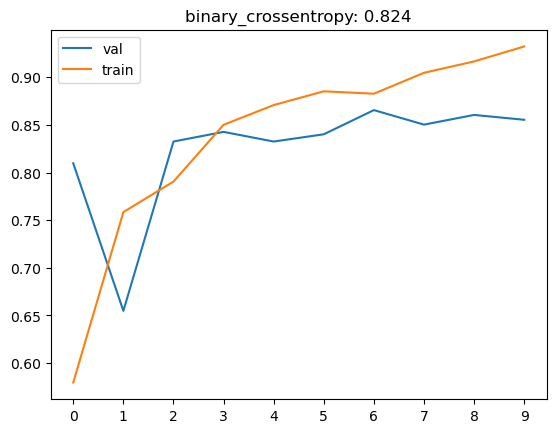

binary_crossentropy: 0.8553299307823181
  training accuracy: 0.88
 standard deviation: 0.15


In [17]:
model, pred2 = eval_model2()

### Question 3

What is the median of training accuracy for all the epochs for this model?

- 0.40
- 0.60
- **0.90**
- 0.20

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

- **0.11**
- 0.66
- 0.99
- 0.33

## Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [18]:
def gen_train_test_sets3(training, testing, target_size=(150, 150)):
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    train_ds = train_gen.flow_from_directory(
        training,
        target_size=target_size,
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=42,
    )

    test_gen = ImageDataGenerator(rescale=1./255)
    test_ds = test_gen.flow_from_directory(
        testing,
        target_size=target_size,
        batch_size=1,
        class_mode='binary',
        shuffle=True,
        seed=42,
    )
    
    return train_ds, test_ds

In [19]:
train_ds, test_ds = gen_train_test_sets3(training_data, testing_data)
    
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
)

score = model.evaluate_generator(generator=test_ds)[1]
predictions = evaluate_model(model, train_ds, test_ds)
print(f'        binary_crossentropy: {score}')
print(f'       mean validation loss: {np.mean(history.history["val_loss"]):.2f}')
print(f'average validation accuracy: {np.mean(history.history["accuracy"][:-5]):.2f}')

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Epoch 1/10
80/80 [==============================] - 32s 395ms/step - loss: 0.4414 - accuracy: 0.7936 - val_loss: 0.3056 - val_accuracy: 0.8553
Epoch 2/10
80/80 [==============================] - 31s 389ms/step - loss: 0.4233 - accuracy: 0.8043 - val_loss: 0.6142 - val_accuracy: 0.7284
Epoch 3/10
80/80 [==============================] - 32s 394ms/step - loss: 0.4363 - accuracy: 0.7999 - val_loss: 0.3954 - val_accuracy: 0.8147
Epoch 4/10
80/80 [==============================] - 32s 395ms/step - loss: 0.3942 - accuracy: 0.8243 - val_loss: 0.6157 - val_accuracy: 0.7310
Epoch 5/10
80/80 [==============================] - 31s 390ms/step - loss: 0.3775 - accuracy: 0.8413 - val_loss: 0.7040 - val_accuracy: 0.7183
Epoch 6/10
80/80 [==============================] - 32s 397ms/step - loss: 0.3790 - accuracy: 0.8419 - val_loss: 0.4544 - val_accuracy: 0.7944
Epoch 7/10
80/80 [==============================] - 32s 395

### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
Make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of validation loss for all the epochs for the model trained with augmentations?

- 0.15
- 0.77
- **0.37**
- 0.97

### Question 6

What's the average of validation accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

- **0.84**
- 0.54
- 0.44
- 0.24

## Using the model

In [20]:
from random import sample

sample_imgs = sample(test_ds.filepaths, 9)
sample_imgs

['data/test/dino/cbe4a26d-f632-451a-915a-78bb757cb364.jpg',
 'data/test/dino/3185a551-1acf-4d4e-8b76-12070eb00301.jpg',
 'data/test/dino/2f5889d2-ea70-4bbb-af6c-46b44da7df1d.jpg',
 'data/test/dino/73186c5b-fb0a-4931-b052-5e437c2105b5.jpg',
 'data/test/dragon/8157a359-e460-41ba-ac7e-c1c8253de44b.jpg',
 'data/test/dragon/6d26ce94-c8f5-4884-970d-f1bf952e2894.jpg',
 'data/test/dino/eaa7fdd4-7e6a-4581-ab00-4903f87baaa2.jpg',
 'data/test/dino/001db8b8-33ff-44b3-8f50-325f4ab4f713.jpg',
 'data/test/dino/e06512b3-2a26-4458-a39e-c6f0a71c94e2.jpg']

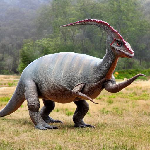

In [21]:
img = load_img(sample_imgs[0], target_size=(150, 150))
img

In [22]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [23]:
pred = model.predict(X)
pred

1/1 [==============================] - 0s 58ms/step


array([[0.]], dtype=float32)

In [24]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [30]:
def classify(file, target_size=(150, 150)):
    mapping = dict((value, key) for key, value in train_ds.class_indices.items())
    actual = file.split('/')[2]
    img = load_img(file, target_size=target_size)
    x = np.array(img)
    X = np.array([x])
    pred = model.predict(X)
    try:
        result = mapping[pred[0][0]]
        matched = 'correct' if result == actual else 'wrong'
        print(f'{result}: ({matched})')
    except KeyError:
        print(f'Unable to classify: {pred[0][0]}')
    display(img)

1/1 [==============================] - 0s 20ms/step
dino: (correct)


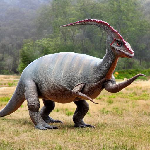

In [26]:
classify(sample_imgs[0])

1/1 [==============================] - 0s 21ms/step
dino: (correct)


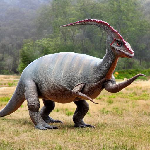

1/1 [==============================] - 0s 18ms/step
dragon: (wrong)


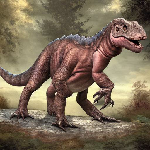

1/1 [==============================] - 0s 18ms/step
dragon: (wrong)


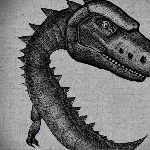

1/1 [==============================] - 0s 18ms/step
dino: (correct)


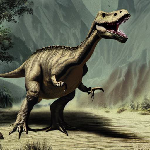

1/1 [==============================] - 0s 18ms/step
dragon: (correct)


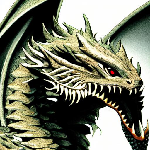

1/1 [==============================] - 0s 18ms/step
dragon: (correct)


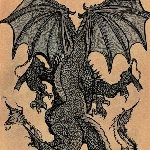

1/1 [==============================] - 0s 18ms/step
dragon: (wrong)


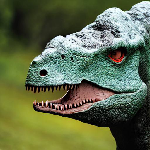

1/1 [==============================] - 0s 18ms/step
dragon: (wrong)


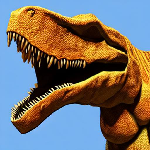

1/1 [==============================] - 0s 18ms/step
Unable to classify: 2.6629654229557482e-27


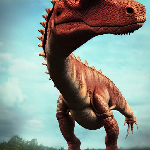

In [31]:
for file in sample_imgs:
    classify(file)

## Save the model

In [32]:
model.save('dino-cnn.h5')